# Twitter Bot Detection: Classification Modeling


The goal of this project is to use machine learning classification models to detect whether a Twitter user is a bot based on account-level information (e.g. number of followers, number of tweets, etc.). This approach will *not* look at the actual contents of tweets. 

After exploring the data and identifying and engineering some potential features, I'll evaluate several classification models to find the best one for Twitter bot detection.

I'll be searching for models that have balanced scores between precision and recall and strong ROC AUC scores -- while I want the model to accurately label bots as often as possible, I also want to reduce misclassification and not simply label *everything* as a bot.

**Process**
1. Evaluate 'out-of-the-box' models and narrow down candidates to 2-3 models based on cross-validated scoring metrics.
2. Consider class-weight balancing (data is ~70/30 split human/bot)
3. Refine feature selection and tune candidate model parameters
4. Consider ensembling best models with VotingClassifier model
5. Pick best model, and perform full train and test
6. Train best model on full data set and pickle to be used in Flask app

In [2]:
import sklearn
print(sklearn.__version__)

1.3.2


In [3]:
# Basics
import pandas as pd
import psycopg2 as pg
import numpy as np
import pickle

# Visuals
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from model_evaluation import *

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Model support
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score, auc,
                             precision_score, recall_score, roc_auc_score, roc_curve, 
                             precision_recall_curve)

## Data import and set up

Importing data from SQL database and setting up features/interactions from EDA notebook to be used in modeling

In [4]:
import json

# Replace 'file_path' with the actual path to your JSON file
with open('profileBotorNot.json', 'r', encoding='utf-8') as file:
    raw_df = json.load(file)


# Convert JSON to DataFrame
df = pd.DataFrame(raw_df)
df.head()

# Now you can work with the 'data' variable, which contains the JSON data

,id,username,displayName,url,intro,join_date,location,friends_count,favorite_count,followers_count,media_count,status_count,listed_count,is_protected,is_verified,account_type
0,787405734442958848,best_in_dumbest,The Best In Dumbest,https://twitter.com/best_in_dumbest,"Blame @MoistHorse, Inspired by @MakingInvisibl...",2016-10-15T21:32:11+00:00,,6,6,1901,18885,18910,50,None,False,bot
1,796216118331310080,CJRubinPhoto,CJ Rubin,https://twitter.com/CJRubinPhoto,Photographing the American West since 1980. I ...,2016-11-09T05:01:30+00:00,United States,781,426,746,110,251,5,None,False,human
2,875949740503859204,SVGEGENT,🔥𝖙𝖍𝖊 𝖘𝖆𝖛𝖆𝖌𝖊 𝖌𝖊𝖓𝖙𝖑𝖊𝖒𝖆𝖓🔥,https://twitter.com/SVGEGENT,Death Metal Barbarian & RPG Nerd ...,2017-06-17T05:34:27+00:00,,1659,11319,390,568,1870,3,None,False,human
3,756119643622735875,TinkTinkEDU,Danielle Tinker,https://twitter.com/TinkTinkEDU,Wife.Godmother.Friend.Feline Fanatic!!!!!!!!! ...,2016-07-21T13:32:25+00:00,"Birmingham, AL",865,21077,815,735,3008,2,None,False,human
4,464781334,JoleonLescott,Joleon Lescott,https://twitter.com/JoleonLescott,England U21 Assistant Coach | @pumafootball Am...,2012-01-15T16:32:35+00:00,"England, United Kingdom",133,724,718036,306,4874,1725,None,False,human


In [5]:
# drop funny index column

# Binary classifications for bots and boolean values
df['bot'] = df['account_type'].apply(lambda x: 1 if x == 'bot' else 0)

In [6]:
df

,id,username,displayName,url,intro,join_date,location,friends_count,favorite_count,followers_count,media_count,status_count,listed_count,is_protected,is_verified,account_type,bot
0,787405734442958848,best_in_dumbest,The Best In Dumbest,https://twitter.com/best_in_dumbest,"Blame @MoistHorse, Inspired by @MakingInvisibl...",2016-10-15T21:32:11+00:00,,6,6,1901,18885,18910,50,None,False,bot,1
1,796216118331310080,CJRubinPhoto,CJ Rubin,https://twitter.com/CJRubinPhoto,Photographing the American West since 1980. I ...,2016-11-09T05:01:30+00:00,United States,781,426,746,110,251,5,None,False,human,0
2,875949740503859204,SVGEGENT,🔥𝖙𝖍𝖊 𝖘𝖆𝖛𝖆𝖌𝖊 𝖌𝖊𝖓𝖙𝖑𝖊𝖒𝖆𝖓🔥,https://twitter.com/SVGEGENT,Death Metal Barbarian & RPG Nerd ...,2017-06-17T05:34:27+00:00,,1659,11319,390,568,1870,3,None,False,human,0
3,756119643622735875,TinkTinkEDU,Danielle Tinker,https://twitter.com/TinkTinkEDU,Wife.Godmother.Friend.Feline Fanatic!!!!!!!!! ...,2016-07-21T13:32:25+00:00,"Birmingham, AL",865,21077,815,735,3008,2,None,False,human,0
4,464781334,JoleonLescott,Joleon Lescott,https://twitter.com/JoleonLescott,England U21 Assistant Coach | @pumafootball Am...,2012-01-15T16:32:35+00:00,"England, United Kingdom",133,724,718036,306,4874,1725,None,False,human,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22149,1390320662,Plasstastic,Elon Musky 🐀,https://twitter.com/Plasstastic,"Living life at 6,253’",2013-04-29T19:46:15+00:00,"Idaho, USA",1638,87137,1152,1604,42655,14,None,False,human,0
22150,43949085,RealJakeHager,Jake Hager,https://twitter.com/RealJakeHager,#AEW #fighter #LFR,2009-06-01T19:16:54+00:00,,1654,4066,897857,1200,6824,3004,None,False,human,0
22151,112368673,theEcobabe,Monica Richards,https://twitter.com/theEcobabe,go green. in style. 🌿 it’s easy to be eco. and...,2010-02-08T07:13:54+00:00,Los Angeles,618,2141,1601,920,3603,18,None,False,human,0
22152,22977574,driaJ03,Naturallyblu🐶,https://twitter.com/driaJ03,I love the Lord. Wife. Mother. Leader. ZPhiB F...,2009-03-05T20:56:50+00:00,Zetaland,988,15055,152,304,4929,0,None,False,NaN,0


In [7]:
# Interesting features to look at:
import pandas as pd
from datetime import datetime

# Tạo một DataFrame ví dụ

# Chuyển đổi cột 'join_date' sang kiểu dữ liệu datetime
df['join_date'] = pd.to_datetime(df['join_date'])

# Ngày hiện tại
current_date = datetime.now()

# Tính số tháng từ ngày tham gia đến nay
df['months_since_join'] = df['join_date'].apply(lambda x: (current_date.year - x.year) * 12 + (current_date.month - x.month))
df['average_tweets_per_month']= np.round((df['status_count'] / df['months_since_join']), 3)

df['avg_monthly_followers'] = np.round((df['followers_count'] / df['months_since_join']), 3)
df['avg_monthly_friends'] = np.round((df['friends_count'] / df['months_since_join']), 3)
df['avg_monthly_favorites'] = np.round((df['favorite_count'] / df['months_since_join']), 3)

# Log transformations for highly skewed data
df['friends_log'] = np.round(np.log(1 + df['friends_count']), 3)
df['followers_log'] = np.round(np.log(1 + df['followers_count']), 3)
df['fav_log'] = np.round(np.log(1 + df['favorite_count']), 3)
df['avg_monthly_tweets_log'] = np.round(np.log(1+ df['average_tweets_per_month']), 3)

# Possible interactive features
df['network'] = np.round(df['friends_log'] * df['followers_log'], 3)
df['tweet_to_followers'] = np.round(np.log( 1 + df['status_count']) * np.log(1+ df['followers_count']), 3)

# Log-transformed daily acquisition metrics for dist. plots
df['follower_acq_rate'] = np.round(np.log(1 + (df['followers_count'] / df['months_since_join'])), 3)
df['friends_acq_rate'] = np.round(np.log(1 + (df['friends_count'] / df['months_since_join'])), 3)
df['favs_rate'] = np.round(np.log(1 + (df['friends_count'] / df['months_since_join'])), 3)

In [8]:
df.head()

,id,username,displayName,url,intro,join_date,location,friends_count,favorite_count,followers_count,...,avg_monthly_favorites,friends_log,followers_log,fav_log,avg_monthly_tweets_log,network,tweet_to_followers,follower_acq_rate,friends_acq_rate,favs_rate
0,787405734442958848,best_in_dumbest,The Best In Dumbest,https://twitter.com/best_in_dumbest,"Blame @MoistHorse, Inspired by @MakingInvisibl...",2016-10-15 21:32:11+00:00,,6,6,1901,...,0.070,1.946,7.551,1.946,5.398,14.694,74.355,3.140,0.067,0.067
1,796216118331310080,CJRubinPhoto,CJ Rubin,https://twitter.com/CJRubinPhoto,Photographing the American West since 1980. I ...,2016-11-09 05:01:30+00:00,United States,781,426,746,...,5.012,6.662,6.616,6.057,1.374,44.076,36.583,2.280,2.321,2.321
2,875949740503859204,SVGEGENT,🔥𝖙𝖍𝖊 𝖘𝖆𝖛𝖆𝖌𝖊 𝖌𝖊𝖓𝖙𝖑𝖊𝖒𝖆𝖓🔥,https://twitter.com/SVGEGENT,Death Metal Barbarian & RPG Nerd ...,2017-06-17 05:34:27+00:00,,1659,11319,390,...,145.115,7.415,5.969,9.334,3.218,44.260,44.970,1.792,3.103,3.103
3,756119643622735875,TinkTinkEDU,Danielle Tinker,https://twitter.com/TinkTinkEDU,Wife.Godmother.Friend.Feline Fanatic!!!!!!!!! ...,2016-07-21 13:32:25+00:00,"Birmingham, AL",865,21077,815,...,236.820,6.764,6.704,9.956,3.550,45.346,53.698,2.318,2.372,2.372
4,464781334,JoleonLescott,Joleon Lescott,https://twitter.com/JoleonLescott,England U21 Assistant Coach | @pumafootball Am...,2012-01-15 16:32:35+00:00,"England, United Kingdom",133,724,718036,...,5.063,4.898,13.484,6.586,3.558,66.045,114.507,8.522,0.658,0.658


First round of feature selection - these should be accessible by all modeling types.

In [9]:
features = ['is_verified', 
            #'created_at',
            #'hour_created',
            #'lang',
            #'acct_location',
            'favorite_count', 
            'followers_count', 
            'friends_count', 
            'status_count', 
            'average_tweets_per_month',
            'avg_monthly_tweets_log',
            'avg_monthly_followers', 
            'avg_monthly_friends',
           'avg_monthly_favorites',
            'network', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
            'favs_rate'
           ]

X = df[features]
y = df['bot']

In [10]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=1234)

## Basic model evaluation

**Models to be evaluated**
* KNearestNeighbors
* LogisticRegression
* NaiveBayes (Gaussian, Bernoulli, Multinomial)
* DecicionTree
* RandomForest
* XGBoost

In [11]:
# Models that require scaling: 
knn = KNeighborsClassifier(n_neighbors=10)
lr = LogisticRegression()

# Scaling
scalar = StandardScaler()
scalar.fit(X)
X_train_scaled = scalar.transform(X)

model_list = [knn, lr]
kf = KFold(n_splits=5, shuffle=True, random_state=33)

In [12]:
multi_model_eval(model_list, X_train_scaled, y, kf)

Model: KNeighborsClassifier(n_neighbors=10)
------------------------------
Accuracy:  0.82227 +- 0.005096
Precision: 0.78266 +- 0.015661
Recall:    0.63833 +- 0.013096
F1 Score:  0.70305 +- 0.011052
ROC AUC:   0.87317 +- 0.003900

Model: LogisticRegression()
------------------------------
Accuracy:  0.80538 +- 0.006934
Precision: 0.71871 +- 0.010906
Recall:    0.67355 +- 0.020515
F1 Score:  0.69522 +- 0.012520
ROC AUC:   0.84527 +- 0.004417



In [13]:
# Models that don't require scaling
gnb = GaussianNB()
bnb = BernoulliNB()
mnb = MultinomialNB()
tree = DecisionTreeClassifier()
forest = RandomForestClassifier()
xgb = XGBClassifier()

model_list = [gnb, bnb, mnb, tree, forest, xgb]
kf = KFold(n_splits=3, shuffle=True, random_state=33)

In [14]:
multi_model_eval(model_list, X, y, kf)

Model: GaussianNB()
------------------------------
Accuracy:  0.48823 +- 0.021940
Precision: 0.38940 +- 0.004462
Recall:    0.96851 +- 0.003359
F1 Score:  0.55545 +- 0.004519
ROC AUC:   0.81653 +- 0.007611

Model: BernoulliNB()
------------------------------
Accuracy:  0.73760 +- 0.005837
Precision: 0.66884 +- 0.012502
Recall:    0.40533 +- 0.013370
F1 Score:  0.50461 +- 0.011521
ROC AUC:   0.65043 +- 0.005847

Model: MultinomialNB()
------------------------------
Accuracy:  0.47043 +- 0.003480
Precision: 0.38214 +- 0.006624
Recall:    0.98159 +- 0.002574
F1 Score:  0.55008 +- 0.007167
ROC AUC:   0.59753 +- 0.004750

Model: DecisionTreeClassifier()
------------------------------
Accuracy:  0.80970 +- 0.003246
Precision: 0.70895 +- 0.013965
Recall:    0.71797 +- 0.001625
F1 Score:  0.71334 +- 0.006254
ROC AUC:   0.78644 +- 0.002353

Model: RandomForestClassifier()
------------------------------
Accuracy:  0.86387 +- 0.002086
Precision: 0.83093 +- 0.012728
Recall:    0.73762 +- 0.006304


RandomForest and XGBoost seem most promising in terms of balance between Precision and Recall metrics and high ROC AUC scores. 

Next I'll plot out the Precision-Recall and ROC Curves for each under KFolds cross-validation.

Average AUC Score: 0.9159 +- 0.002910


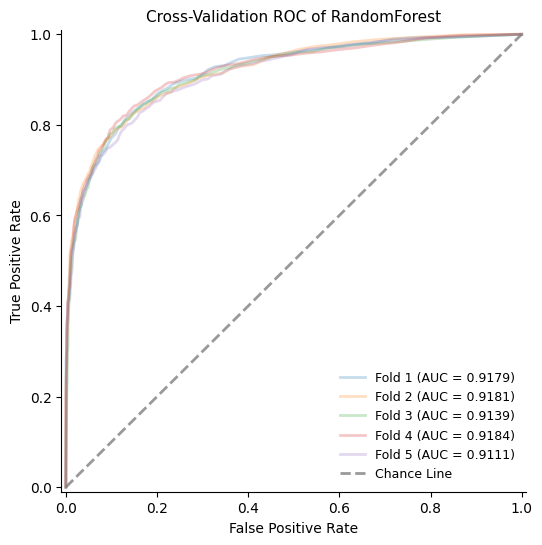

In [15]:
forest = RandomForestClassifier()
kf = KFold(n_splits=5, shuffle=True, random_state=33)

roc_curve_cv(forest, X, y, kf, model_alias='RandomForest')

Average Precision Score: 0.8323 +- 0.012936
Average Recall Score: 0.7315 +- 0.009348


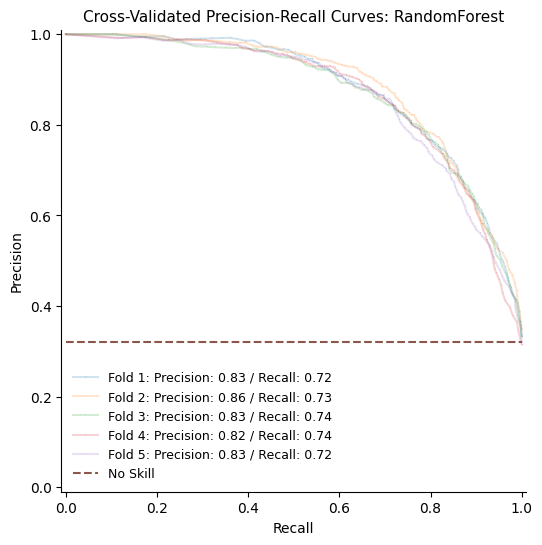

In [16]:
precision_recall_cv(forest, X, y, kf, model_alias='RandomForest')

Average AUC Score: 0.9145 +- 0.002346


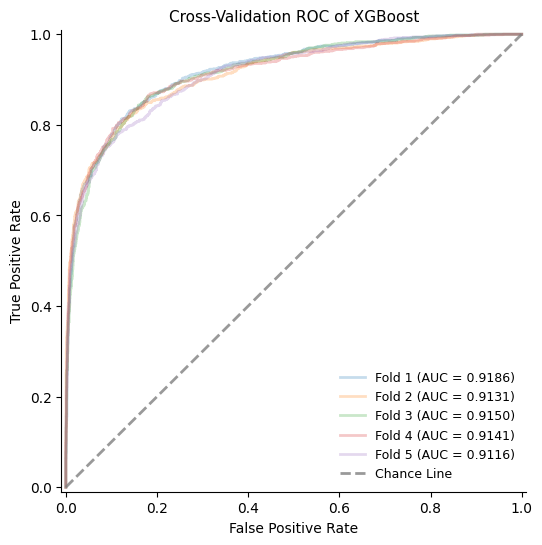

In [17]:
xgb = XGBClassifier()

kf = KFold(n_splits=5, shuffle=True, random_state=33)

roc_curve_cv(xgb, X, y, kf, model_alias='XGBoost')

Average Precision Score: 0.8230 +- 0.014926
Average Recall Score: 0.7363 +- 0.007305


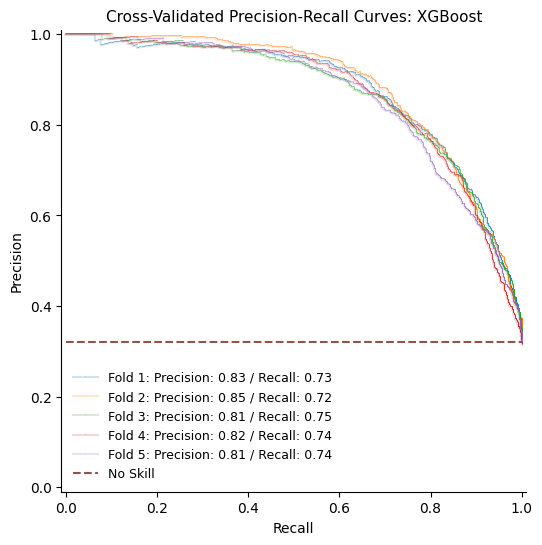

In [18]:
precision_recall_cv(xgb, X, y, kf, model_alias='XGBoost')

RF has a slight edge, but I think it's too close to call with the out of the box models. Next I'll see what kind of effect rebalancing class weights has on the models.

## Class weight balancing

In [19]:
num_bots = len(df[df['bot'] == 1])
num_humans = len(df[df['bot'] == 0])

print("Number of bots: ", num_bots)
print("Number of humans: ", num_humans)
print(f'Bots / Total %: {(num_bots / len(df))*100:.2f}')

Number of bots:  7368
Number of humans:  14786
Bots / Total %: 33.26


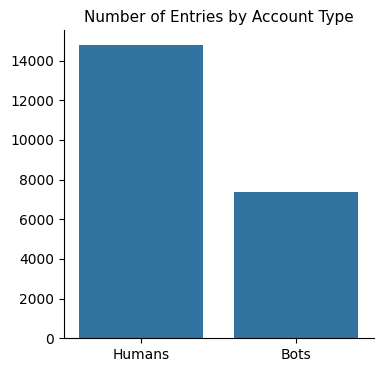

In [20]:
types = ['Humans', 'Bots']
counts = [num_humans, num_bots]

plt.figure(figsize=(4, 4))
sns.barplot(x = types, y = counts)
plt.title("Number of Entries by Account Type", fontsize=11)
sns.despine()

In [21]:
# For XGBoost
estimate = num_humans/num_bots
estimate

2.006786102062975

In [22]:
forest = RandomForestClassifier(class_weight='balanced')
xgb = XGBClassifier(scale_pos_weight=estimate)

models = [forest, xgb]
kf = KFold(n_splits=5, shuffle=True, random_state=33)

In [23]:
multi_model_eval(models, X, y, kf)

Model: RandomForestClassifier(class_weight='balanced')
------------------------------
Accuracy:  0.86271 +- 0.002613
Precision: 0.83795 +- 0.013035
Recall:    0.72374 +- 0.007133
F1 Score:  0.77657 +- 0.005075
ROC AUC:   0.91423 +- 0.002824

Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None

RF doesn't change that much but RF's Recall score downed 

Let's look at a the curves.

### Cross-Validated Precision-Recall and ROC Curves

#### RandomForest

Average AUC Score: 0.9158 +- 0.002997


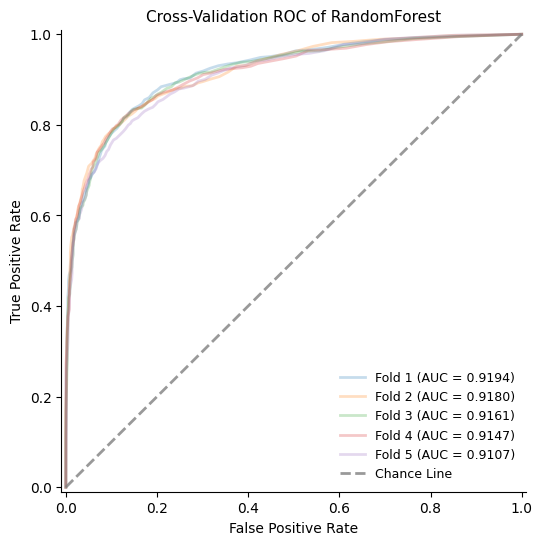

In [24]:
roc_curve_cv(forest, X, y, kf, model_alias='RandomForest')

Average Precision Score: 0.8402 +- 0.011617
Average Recall Score: 0.7242 +- 0.010836


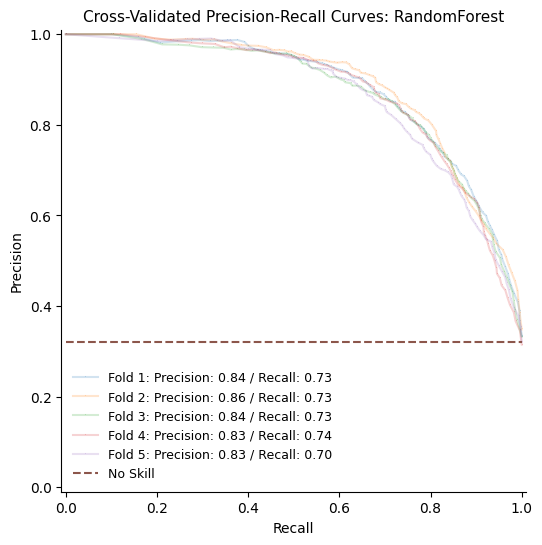

In [25]:
precision_recall_cv(forest, X, y, kf, model_alias='RandomForest')

#### XGBoost

Average AUC Score: 0.9125 +- 0.002541


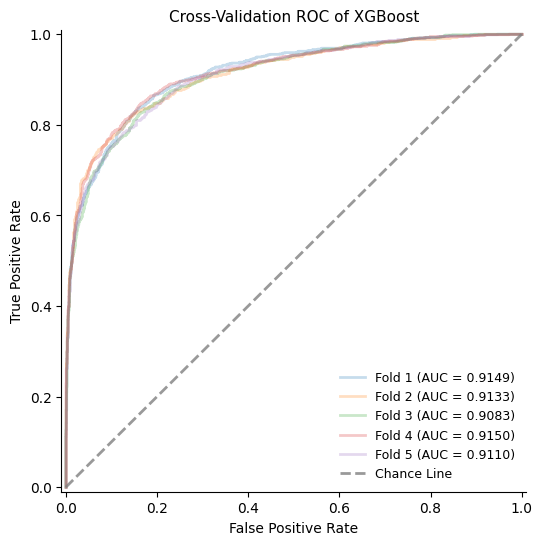

In [26]:
roc_curve_cv(xgb, X, y, kf, model_alias='XGBoost')

Average Precision Score: 0.7642 +- 0.020873
Average Recall Score: 0.7826 +- 0.005460


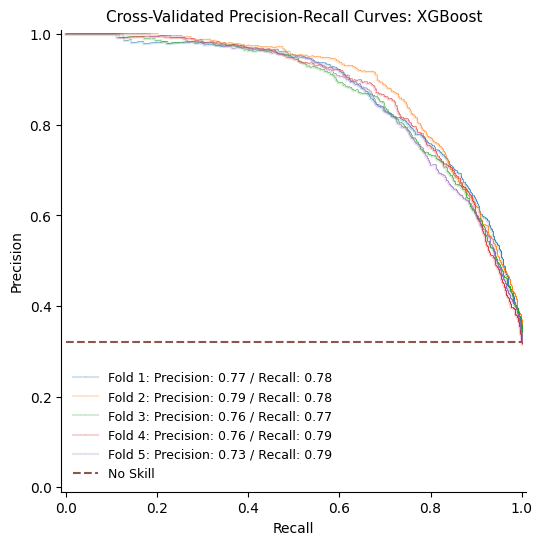

In [27]:
precision_recall_cv(xgb, X, y, kf, model_alias='XGBoost')

### Confusion Matrices

Let's take a look at the confusion matrices of each model for a single train/test split.

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3333)

#### RandomForest

In [29]:
forest = RandomForestClassifier(class_weight='balanced')

forest.fit(X_train, y_train)
preds = forest.predict(X_val)

Classification Metrics Report
-----------------------------
Accuracy:  0.8574
Precision: 0.8294
Recall:    0.7046
F1 Score:  0.7619

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2621
           1       0.83      0.70      0.76      1256

    accuracy                           0.86      3877
   macro avg       0.85      0.82      0.83      3877
weighted avg       0.86      0.86      0.85      3877




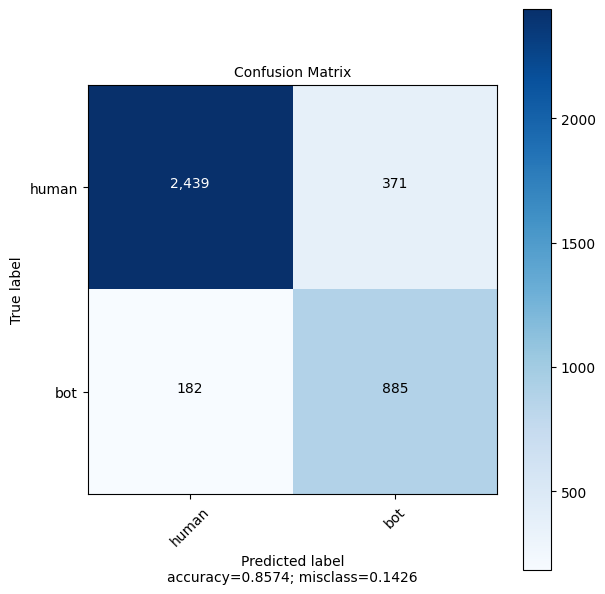

In [30]:
metrics_report(preds, y_val)

#### XGBoost

In [31]:
xgb = XGBClassifier(scale_pos_weight=estimate)

xgb.fit(X_train, y_train)
preds = xgb.predict(X_val)

Classification Metrics Report
-----------------------------
Accuracy:  0.8483
Precision: 0.7689
Recall:    0.7604
F1 Score:  0.7646

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      2621
           1       0.77      0.76      0.76      1256

    accuracy                           0.85      3877
   macro avg       0.83      0.83      0.83      3877
weighted avg       0.85      0.85      0.85      3877




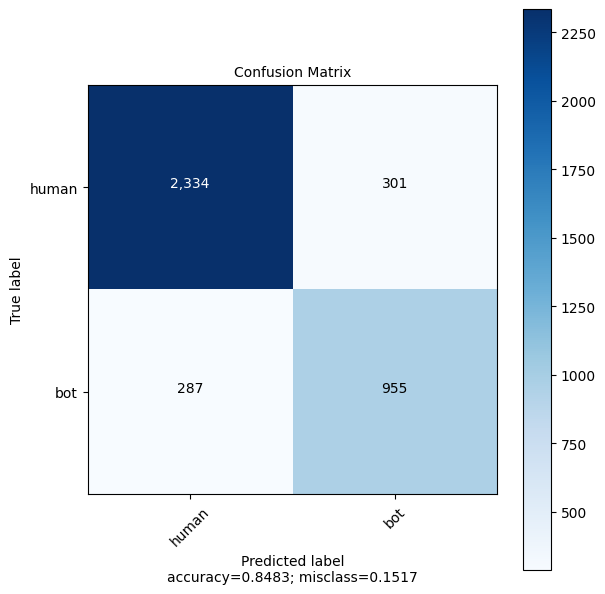

In [32]:
metrics_report(preds, y_val)

### Feature Importance

How does each model use the features? 

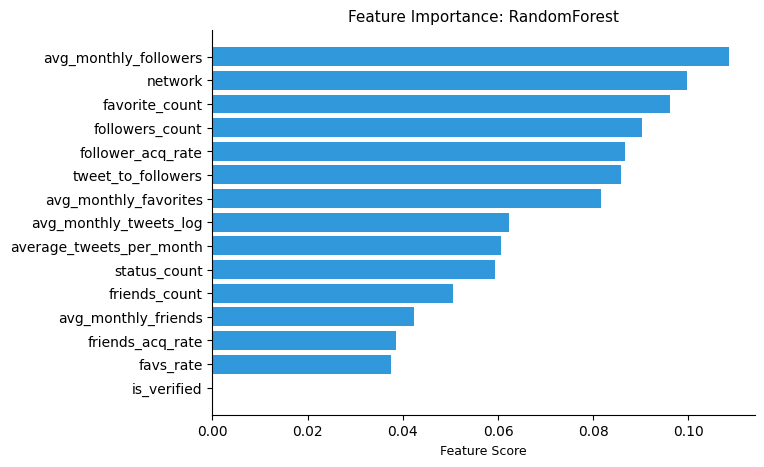

In [32]:
plot_feature_importance(forest, features, model_alias='RandomForest')

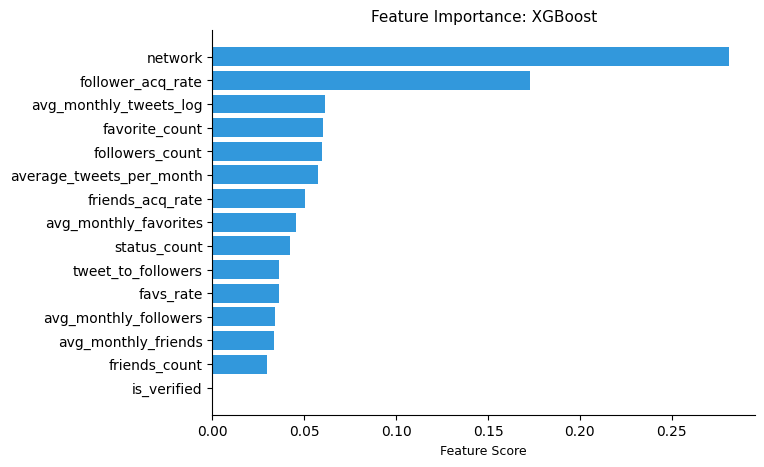

In [34]:
plot_feature_importance(xgb, features, model_alias='XGBoost')

It's actually quite interesting how each model uses the features! Network is important for both, but the rest is pretty scattered. follower_acq_rate and favorite_count seems pretty important in both, so does average tweets per day. I'm surprised thatboth XGBoost and  RandomForest doesn't have verified as more important.

What's also interesting to note is that the feature scores in XGBoost are much more even than RF - where network is very high and the rest are much smaller.

If I had to pick one model right now, it'd be RF based on the better balance between precision and recall. I still want to take another look at features, continue to tune model parameters, and possibly ensembling RandomForest and XGBoost to create a super model. 

## Continued Tuning and Feature Selection

In [35]:
df.head(3)

,id,username,displayName,url,intro,join_date,location,friends_count,favorite_count,followers_count,...,avg_monthly_favorites,friends_log,followers_log,fav_log,avg_monthly_tweets_log,network,tweet_to_followers,follower_acq_rate,friends_acq_rate,favs_rate
0,787405734442958848,best_in_dumbest,The Best In Dumbest,https://twitter.com/best_in_dumbest,"Blame @MoistHorse, Inspired by @MakingInvisibl...",2016-10-15 21:32:11+00:00,,6,6,1901,...,0.070,1.946,7.551,1.946,5.398,14.694,74.355,3.140,0.067,0.067
1,796216118331310080,CJRubinPhoto,CJ Rubin,https://twitter.com/CJRubinPhoto,Photographing the American West since 1980. I ...,2016-11-09 05:01:30+00:00,United States,781,426,746,...,5.012,6.662,6.616,6.057,1.374,44.076,36.583,2.280,2.321,2.321
2,875949740503859204,SVGEGENT,🔥𝖙𝖍𝖊 𝖘𝖆𝖛𝖆𝖌𝖊 𝖌𝖊𝖓𝖙𝖑𝖊𝖒𝖆𝖓🔥,https://twitter.com/SVGEGENT,Death Metal Barbarian & RPG Nerd ...,2017-06-17 05:34:27+00:00,,1659,11319,390,...,145.115,7.415,5.969,9.334,3.218,44.260,44.970,1.792,3.103,3.103


In [36]:
features = ['is_verified', 
            #'created_at',
            #'hour_created',
            #'lang',
            #'acct_location',
            'favorite_count', 
            'followers_count', 
            'friends_count', 
            'status_count', 
            'average_tweets_per_month',
            'avg_monthly_tweets_log',
            'avg_monthly_followers', 
            'avg_monthly_friends',
           'avg_monthly_favorites',
            'network', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
            'favs_rate'
           ]

X = df[features]
y = df['bot']

X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=1234)

### Finding the best RF Model

In [37]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [5, 7, 9],
#     'min_samples_split': [2, 4, 6],
#     'min_samples_leaf': [1, 2, 3]
# }

# # Create the RandomForestClassifier object
# rf = RandomForestClassifier(random_state=42)

# # Perform grid search
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
# grid_search.fit(X, y)

# # Get the best parameters and best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_
# best_rf = RandomForestClassifier(random_state=42, **best_params)

In [38]:
xgb = XGBClassifier(scale_pos_weight=1.8, 
                    tree_method='hist', 
                    learning_rate=0.1,           
                    eta=0.01,                 
                    max_depth=7,                
                    gamma=0.05,
                    n_estimators=200,
                    colsample_bytree=.8
                   )

# model_list = [xgb]
#rf = RandomForestClassifier(class_weight='balanced')
# rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
# max_depth=7,
# min_samples_leaf=1, min_samples_split=4,
# min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
# oob_score=False, random_state=None, verbose=0,
# warm_start=False
# )
model_list = [xgb]

In [39]:
kf = KFold(n_splits=5, shuffle=True, random_state=33)

multi_model_eval(model_list, X, y, kf)

Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, gamma=0.05, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)
------------------------------
Accuracy:  0.85761 +- 0.006156
Precision: 0.78767 +- 0.017457
Recall:    0.77853 +- 0.005413
F1 Score:  0.78293 +- 0.007358
ROC AUC:   0.91677 +- 0.002116



I think these are pretty solid scores and this is the most balanced version of the model I've been able to come up with thus far. Let's take a look at the curves. 

Average AUC Score: 0.9168 +- 0.002116


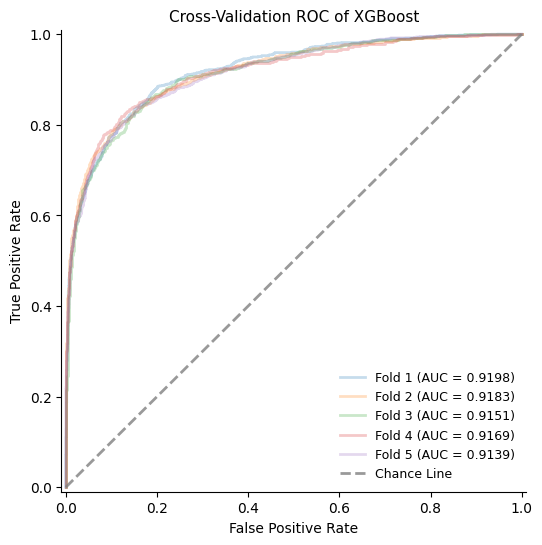

In [40]:
roc_curve_cv(xgb, X, y, kf, model_alias='XGBoost')

Average Precision Score: 0.7877 +- 0.017457
Average Recall Score: 0.7785 +- 0.005413


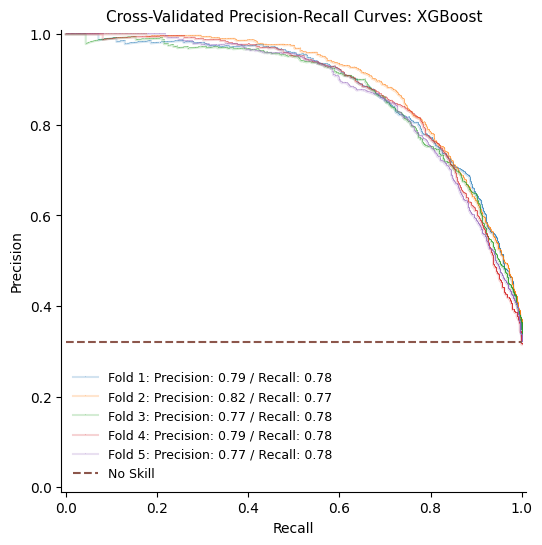

In [41]:
precision_recall_cv(xgb, X, y, kf, model_alias='XGBoost')

I like these scores a lot. Still, let's try ensembling RandomForest with XGBoost.

### Ensembling with VotingClassifier

In [42]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=1234)

In [43]:
forest = RandomForestClassifier(class_weight='balanced')
forest = forest.fit(X_train, y_train)

xgb = XGBClassifier(scale_pos_weight=1.8, 
                    tree_method='hist', 
                    learning_rate=0.1,      
                    eta=0.01,                 
                    max_depth=7,                
                    gamma=0.05,
                    n_estimators=200,
                    colsample_bytree=.8)

xgb = xgb.fit(X_train, y_train)

In [44]:
models = [('forest', forest), ('xgb', xgb)]

voting_classifier = VotingClassifier(estimators=models,
                                     voting='soft',
                                     n_jobs=-1)

voting_classifier = voting_classifier.fit(X_train, y_train)

Classification Metrics Report
-----------------------------
Accuracy:  0.8597
Precision: 0.8140
Recall:    0.7433
F1 Score:  0.7771

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      3122
           1       0.81      0.74      0.78      1531

    accuracy                           0.86      4653
   macro avg       0.85      0.83      0.84      4653
weighted avg       0.86      0.86      0.86      4653




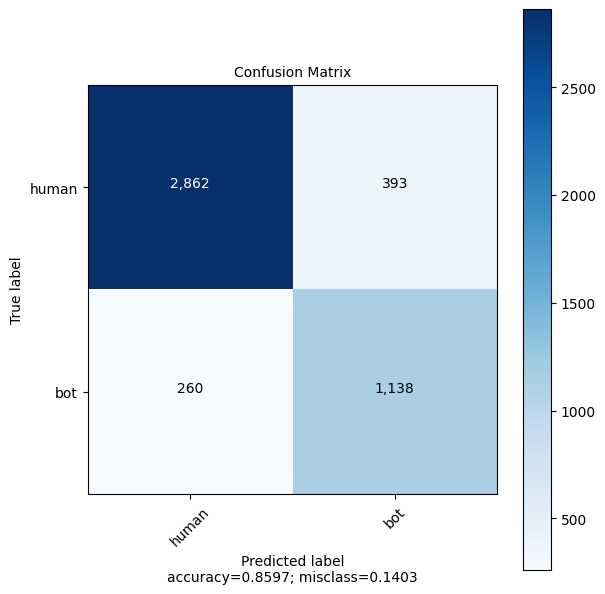

In [45]:
voting_classifier_prediction = voting_classifier.predict(X_val)

metrics_report(voting_classifier_prediction, y_val)

Better! 

It's decided - both is the winning model.

## Best Model: Full Train & Test and Results

Now to train the model on the full training data and test on the hold out set.

In [49]:
# # Full train & test
# best_model = XGBClassifier(scale_pos_weight=1.8, 
#                     tree_method='hist', 
#                     learning_rate=0.1,      
#                     eta=0.01,                 
#                     max_depth=7,                
#                     gamma=0.05,
#                     n_estimators=200,
#                     colsample_bytree=.8)

In [46]:
best_model = VotingClassifier(estimators=models,
                                     voting='soft',
                                     n_jobs=-1)

In [47]:
best_model.fit(X, y)

VotingClassifier(estimators=[('forest',
                              RandomForestClassifier(class_weight='balanced')),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False, eta=0.01,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.05,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None, ...))],
                 n_jobs=-1, voting='soft')

Classification Metrics Report
-----------------------------
Accuracy:  0.8637
Precision: 0.8239
Recall:    0.7602
F1 Score:  0.7908

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      4395
           1       0.82      0.76      0.79      2252

    accuracy                           0.86      6647
   macro avg       0.85      0.84      0.84      6647
weighted avg       0.86      0.86      0.86      6647




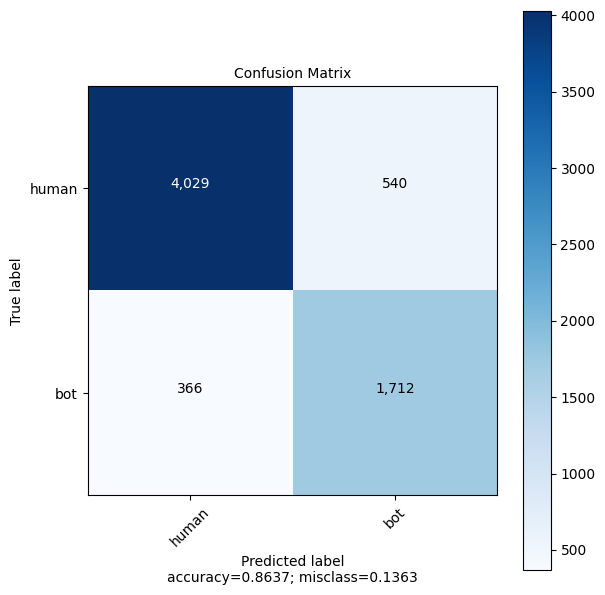

In [48]:
best_model_prediction = best_model.predict(X_test)

metrics_report(best_model_prediction, y_test)

ROC AUC score: 0.9158



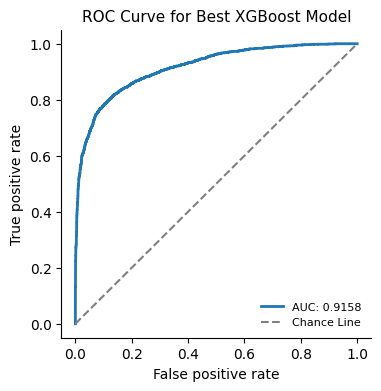

In [50]:
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])

model_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])

plt.figure(figsize=(4, 4), dpi=100)
plt.plot(fpr, tpr,lw=2, label=f'AUC: {model_auc:.4f}')
plt.plot([0,1],[0,1],c='grey',ls='--', label='Chance Line')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate', fontsize=10)
plt.ylabel('True positive rate', fontsize=10)
plt.title('ROC Curve for Best XGBoost Model', fontsize=11)
plt.legend(loc='lower right', prop={'size': 8}, frameon=False)
sns.despine()
print(f'ROC AUC score: {model_auc:.4f}')
print("")
plt.show()

Precision score: 0.8239
Rcall score: 0.7602



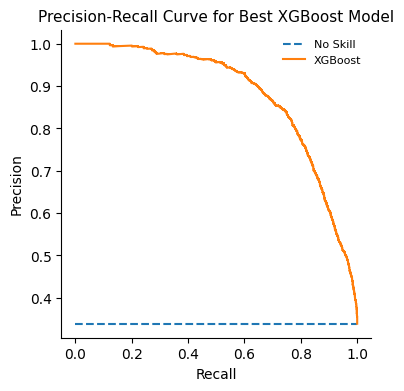

In [51]:
# Prec Recal Curve here

model_precision, model_recall, _ = precision_recall_curve(y_test, best_model.predict_proba(X_test)[:,1])

# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)

plt.figure(figsize=(4, 4), dpi=100)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(model_recall, model_precision, marker=',', label='XGBoost')
# axis labels
plt.title('Precision-Recall Curve for Best XGBoost Model', fontsize=11)
plt.xlabel('Recall', fontsize=10)
plt.ylabel('Precision', fontsize=10)
# show the legend
plt.legend(loc='upper right', prop={'size': 8}, frameon=False)
# show the plot
sns.despine()

pred = best_model.predict(X_test)
prec_score = precision_score(y_test, pred)
rec_score = recall_score(y_test, pred)

print(f'Precision score: {prec_score:.4f}')
print(f'Rcall score: {rec_score:.4f}')
print("")

In [53]:
#plot_feature_importance(best_model, features, model_alias='XGBoost')

Interestingly enough, the model switched Network and Verification statuses in the feature importance rankings. 

## Train model on the data dataset to use for new predictions

Now to train the model on the full dataset and pickle it for later use to make predictions on live Twitter users using their API.

In [54]:
features = ['is_verified', 
            'months_since_join',
            'favorite_count',
            'followers_count', 
            'friends_count', 
            'status_count', 
            'average_tweets_per_month',
            'media_count',
            'listed_count',
            'network', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
           ]

X = df[features]
y = df['bot']

In [55]:
fully_trained_model = VotingClassifier(estimators=models,
                                     voting='soft',
                                     n_jobs=-1)

fully_trained_model.fit(X, y)

VotingClassifier(estimators=[('forest',
                              RandomForestClassifier(class_weight='balanced')),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False, eta=0.01,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.05,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None, ...))],
                 n_jobs=-1, voting='soft')

Save as pickle to use later!

In [56]:
import json

# Replace 'file_path' with the actual path to your JSON file
with open('output_file.json', 'r', encoding='utf-8') as file:
    raw_df = json.load(file)
    
users = [item['user'] for item in raw_df if 'user' in item]


# Convert JSON to DataFrame
df = pd.DataFrame(users)
df.head()

# Now you can work with the 'data' variable, which contains the JSON data

,id,username,displayName,url,intro,join_date,location,friends_count,favorite_count,followers_count,media_count,status_count,listed_count,is_protected,is_verified,ref
0,1680887177884975105,YVolatil58689,yano Volátil,https://twitter.com/YVolatil58689,,2023-07-17T10:28:53+00:00,,38,8,4,0,16,0,None,False,[]
1,1478269476076351488,VioletAbtahi,Violet Abtahi,https://twitter.com/VioletAbtahi,"COO @enyaai | Co-founder @bobanetwork, blockch...",2022-01-04T07:38:16+00:00,"San Francisco, CA",1529,277,1531,9,190,29,None,False,"[{'url': 'http://boba.network', 'text': 'boba...."
2,4265683317,SubhashSaudagar,subhash saudagar,https://twitter.com/SubhashSaudagar,,2015-11-24T16:13:05+00:00,,62,18,12,0,53,0,None,False,[]
3,1723539813200982016,kosmooneth41524,Nonfriend,https://twitter.com/kosmooneth41524,,2023-11-12T03:14:49+00:00,,185,0,1,3,3,0,None,False,[]
4,1655274262821781504,PepeNFTclub,Pepe NFT Club,https://twitter.com/PepeNFTclub,Pepe NFT Club is a collection from PNCLabs. Pi...,2023-05-07T18:12:07+00:00,ETH,1322,183,717,32,108,1,None,False,"[{'url': 'https://shorturl.at/btuDM', 'text': ..."


In [57]:
# Interesting features to look at:
import pandas as pd
from datetime import datetime

# Tạo một DataFrame ví dụ

# Chuyển đổi cột 'join_date' sang kiểu dữ liệu datetime
df['join_date'] = pd.to_datetime(df['join_date'])
df['username'] = df['username'].astype('category')
df['displayName'] = df['displayName'].astype('category')
df['join_date'] = df['join_date'].astype('datetime64[ns, UTC]')
# Repeat this for other categorical columns
# Ngày hiện tại
current_date = datetime.now()

# Tính số tháng từ ngày tham gia đến nay
df['months_since_join'] = df['join_date'].apply(lambda x: (current_date.year - x.year) * 12 + (current_date.month - x.month))
df['average_tweets_per_month']= np.round((df['status_count'] / df['months_since_join']), 3)

df['avg_monthly_followers'] = np.round((df['followers_count'] / df['months_since_join']), 3)
df['avg_monthly_friends'] = np.round((df['friends_count'] / df['months_since_join']), 3)
df['avg_monthly_favorites'] = np.round((df['favorite_count'] / df['months_since_join']), 3)

# Log transformations for highly skewed data
df['friends_log'] = np.round(np.log(1 + df['friends_count']), 3)
df['followers_log'] = np.round(np.log(1 + df['followers_count']), 3)
df['fav_log'] = np.round(np.log(1 + df['favorite_count']), 3)
df['avg_daily_tweets_log'] = np.round(np.log(1+ df['average_tweets_per_month']), 3)

# Possible interactive features
df['network'] = np.round(df['friends_log'] * df['followers_log'], 3)
df['tweet_to_followers'] = np.round(np.log( 1 + df['status_count']) * np.log(1+ df['followers_count']), 3)

# Log-transformed daily acquisition metrics for dist. plots
df['follower_acq_rate'] = np.round(np.log(1 + (df['followers_count'] / df['months_since_join'])), 3)
df['friends_acq_rate'] = np.round(np.log(1 + (df['friends_count'] / df['months_since_join'])), 3)
df['favs_rate'] = np.round(np.log(1 + (df['friends_count'] / df['months_since_join'])), 3)

In [58]:
y_pred = fully_trained_model.predict(df[features])
df['account_type'] = y_pred

In [60]:
df.to_csv('dataset_with_predictions.csv', index=False)


In [63]:
import pandas as pd

# Giả sử df là DataFrame của bạn
# Đếm số lượng tài khoản với account_type = 1
num_accounts_bot = (df['account_type'] == 1).sum()

print("Số lượng tài khoản bot:", num_accounts_bot)

Số lượng tài khoản bot: 7189


In [65]:
import json
import pandas as pd

# Đọc tệp CSV và tạo một từ điển
csv_df = pd.read_csv('dataset_with_predictions.csv')
account_types_dict = pd.Series(csv_df.account_type.values, index=csv_df.id).to_dict()

# Đọc tệp JSON
with open('output_file.json', 'r', encoding='utf-8') as file:
    json_data = json.load(file)

# Cập nhật thông tin account_type cho mỗi người dùng trong tệp JSON
for item in json_data:
    user_id = item['user']['id']
    if user_id in account_types_dict:
        account_type = 'bot' if account_types_dict[user_id] == 1 else 'human'
        item['user']['account_type'] = account_type


# Ghi lại tệp JSON với thông tin đã được cập nhật
with open('data_w_tag.json', 'w', encoding='utf-8') as file:
    json.dump(json_data, file, indent=4)

In [66]:
# Đọc lại tệp JSON đã cập nhật
with open('data_w_tag.json', 'r', encoding='utf-8') as file:
    updated_json_data = json.load(file)

# Lọc ra các người dùng không phải là 'bot'
non_bot_users = [item for item in updated_json_data if item['user']['account_type'] != 'bot']

# Ghi lại tệp JSON với chỉ những người dùng không phải là 'bot'
with open('json_file_no_bots.json', 'w', encoding='utf-8') as file:
    json.dump(non_bot_users, file, indent=4)